# **User Churn Prediction: A Machine Learning Approach for Waze**

This project focuses on predicting monthly user churn for Waze by building and evaluating machine learning models. The objective is to identify users at risk of leaving the platform so that the company could take proactive steps to improve retention and growth.  

## Project Goals
- **Explore and analyze user activity data** to understand patterns associated with churn.  
- **Engineer features** from user behavior data to improve predictive performance.  
- Build and compare classification models **(Random Forest, XGBoost)** to forecast churn.  

## Dataset Overview

The dataset contains **14,999 rows** and **13 columns** of synthetic user activity data. Each row represents an individual Waze user, with churn defined as users who uninstall or stop using the app.  

**Key variables include:**  
- `ID` – A sequential numbered index 
- `label` – Binary target variable (“retained” vs “churned”) for if a user has churned anytime during the course of the month   
- `sessions` – The number of occurrence of a user opening the app during the month
- `drives` – An occurrence of driving at least 1 km during the month 
- `total_sessions` – A model estimate of the total number of sessions since a user has onboarded
- `n_days_after_onboarding` – The number of days since a user signed up for the app  
- `total_navigations_fav1` / `total_navigations_fav2` – Total navigations since onboarding to the user’s favorite place 1 or 2 
- `driven_km_drives` – Total kilometers driven during the month
- `duration_minutes_drives` – Total duration driven in minutes during the month 
- `activity_days` – Number of days the user opens the app during the month 
- `driving_days` – Number of days the user drives (at least 1 km) during the month
- `device` – The type of device a user starts a session with (Android/iPhone)  

## Baseline Model: Logistic Regression

Before developing advanced tree-based models, a logistic regression model was developed in a previous milestone of the project to serve as a baseline. This step was important to establish a simple, interpretable benchmark for comparison.

**Process highlights:**
- **Feature Engineering:**  
  - Created `km_per_driving_day` to capture average distance driven per day.  
  - Engineered `professional_driver` to distinguish high-frequency drivers (≥60 drives and ≥15 driving days) from casual users. Professional drivers showed a churn rate of only 7.6% compared to 19.9% for others, suggesting predictive value.  
- **Data Preparation:**  
  - Dropped ~700 rows with missing labels (<5% of dataset, no non-random cause detected).  
  - Imputed outliers to the 95th percentile for key variables such as `sessions`, `drives`, `total_sessions`, `total_navigations_fav1`, `total_navigations_fav2`, `driven_km_drives`and `duration_minutes_drives`.
  - Encoded categorical features (e.g., `device` type).  
  - Removed multicollinear variables (`sessions` and `driving_days`) to avoid redundancy.  

**Model assumptions checked:**
- Independent observations assumed.  
- Outliers handled via imputation.  
- Multicollinearity reduced by dropping highly correlated variables.  
- Verified approximate linearity between predictors and log-odds.  

**Results:**  
- Accuracy: **82%**  
- Recall for churned users: **9%**  
- Precision for churned users: **52%**  

The model demonstrated high accuracy overall but **very low recall**, meaning it failed to identify most at-risk users. While precision was reasonable, the large number of false negatives limited its usefulness for the business objective of churn prevention.  

**Key takeaway:** Logistic regression provided a valuable baseline, but its limitations in recall motivated the development of more advanced models (Random Forest and XGBoost) to better capture at-risk users.


### **Imports and data loading**

Imported packages and libraries needed to build and evaluate random forest and XGBoost classification models.

In [1]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import packages for data visualization
import matplotlib.pyplot as plt

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

# This is the function that helps plot feature importance
from xgboost import plot_importance

# # This module lets us save our models once we fit them.
import pickle

This project uses a dataset called `waze_dataset.csv`, which contains **synthetic user activity data created for this project in partnership with Waze**.

The initial step involved reading the dataset into a DataFrame (`df0`) and inspecting the first five rows to confirm structure and formatting before moving forward with data exploration and preprocessing.

In [2]:
# Import dataset
df0 = pd.read_csv('waze_dataset.csv')

In [3]:
# Inspect the first five rows
df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


## Feature Engineering  

New features were engineered to capture meaningful aspects of user behavior, such as driving patterns and app engagement frequency.  

To ensure the original dataset remained intact, a working copy of the DataFrame (`df`) was created from `df0`, which served as the basis for all feature engineering and modeling steps.

In [4]:
# Copy the df0 dataframe
df = df0.copy()

To confirm the structure of the working DataFrame and reference existing columns for feature engineering, the `.info()` method was used. This provided an overview of the dataset’s dimensions, column names, and data types.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


### Feature: `km_per_driving_day`  

To better capture driving behavior, a new feature was engineered to represent the **average number of kilometers driven per active driving day** in the last month for each user. This provides a normalized measure of driving intensity..  

Once created, descriptive statistics were generated to understand the distribution of this feature and check for any anomalies or extreme values.

In [6]:
# 1. Create `km_per_driving_day` feature
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# 2. Get descriptive stats
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

During feature creation, some values in `km_per_driving_day` appeared as infinity. This occurred because users with **zero recorded driving days** created division-by-zero cases when calculating the average kilometers per driving day.  

To address this, infinite values were replaced with zeros, ensuring the feature remained meaningful and free of invalid entries. The updated column was then re-examined using `.describe()` to confirm the correction and review its distribution.

In [7]:
# 1. Convert infinite values to zero
df['km_per_driving_day'].replace([np.inf, -np.inf], 0, inplace = True)

# 2. Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

### Feature: `percent_sessions_in_last_month`

Another feature engineered was the **percentage of a user’s total sessions that occurred in the most recent month of activity**. Once again, descriptive statistics were generated.

In [8]:
# 1. Create `percent_sessions_in_last_month` feature
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

# 1. Get descriptive stats
df['percent_sessions_in_last_month'].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

### Feature: `professional_driver`

A binary feature, `professional_driver`, was engineered to identify users who appear to use Waze in a professional capacity. Specifically, users were classified as professional drivers if they had **60 or more total drives** and drove on **15 or more days** within the last month. These thresholds were chosen based on domain intuition (given through course guidance) to separate frequent, work-related driving behavior from casual driving activity.  

This feature helps distinguish professional drivers, who may show different usage patterns and churn risks compared to casual drivers. 

In [9]:
# Create `professional_driver` feature
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

### Feature: `total_sessions_per_day`

A new feature, `total_sessions_per_day`, was engineered to represent the **average number of app sessions per day since onboarding**. This metric makes it easier to compare engagement levels across users who joined at different times.  

In [10]:
# Create `total_sessions_per_day` feature
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

As with other features, generated descriptive statistics for this new feature.

In [11]:
# Get descriptive stats
df['total_sessions_per_day'].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sessions_per_day, dtype: float64

### Feature: `km_per_hour`

The feature `km_per_hour` was created to capture the mean kilometers per hour driven in the last month. 

In [12]:
# Create `km_per_hour` feature
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)
df['km_per_hour'].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_per_hour, dtype: float64

### Feature: `km_per_drive`

The feature `km_per_drive` was engineered to represent the **average distance driven per trip** during the last month.

In [13]:
# Create `km_per_drive` feature
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df['km_per_drive'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

As with `km_per_driving_day`, some values in `km_per_drive` were recorded as infinity due to users with zero recorded drives. These infinite values were replaced with zeros to maintain consistency, and the updated feature was reviewed to confirm the correction.

In [14]:
# 1. Convert infinite values to zero
df['km_per_drive'].replace([np.inf, -np.inf], 0, inplace = True)
# 2. Confirm that it worked
df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

### Feature: `percent_of_sessions_to_favorite`

The feature `percent_of_sessions_to_favorite` was engineered to capture the **percentage of total sessions that were used to navigate to a user’s favorite places**. Since total lifetime drives were not available in this dataset, total sessions served as a practical proxy measure.  

This feature provides behavioral insight into how users rely on Waze: users who frequently drive to non-favorite destinations may be more engaged with the app, as they depend on it for navigation in less familiar contexts, potentially lowering their likelihood of churn.

In [15]:
# Create `percent_of_sessions_to_favorite` feature
df['percent_of_sessions_to_favorite'] = (df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

# Get descriptive stats
df['percent_of_sessions_to_favorite'].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percent_of_sessions_to_favorite, dtype: float64

### Dropping Missing Values

Based on the exploratory analysis conducted in the previous milestone, the 700 missing entries in the `label` column were found to be randomly distributed across the dataset. This was confirmed by comparing the distributions of other features between rows with and without missing `label` values, which showed no significant differences. Since these missing rows represent less than 5% of the total data, it is reasonable to remove them to streamline our analysis. We will use the `dropna()` method to drop these rows.

In [16]:
# Drop rows with missing values
df = df.dropna(subset=['label'])

### Handling Outliers

An earlier exploratory analysis revealed that several columns contain outliers. However, since tree-based models are generally robust to outliers, no imputations or transformations are necessary for these features at this stage.

### Variable Encoding: Dummying Features

To include the `device` column as a feature in our model, we need to convert it into a numeric format since it is categorical. While datasets with many categorical variables often require `pd.get_dummies()` or `OneHotEncoder()` from scikit-learn, our dataset only has this single categorical column remaining. Therefore, we can transform it directly into a binary variable.

We'll create a new column, `device2`, encoding devices as follows:  

- Android: 0  
- iPhone: 1  

This simple binary encoding will allow us to use `device` as an input feature without adding unnecessary complexity to the model.

In [17]:
# Create new `device2` variable
df['device2'] = np.where(df['device'] == 'Android', 0, 1)
df[['device', 'device2']].head()

,device,device2
0,Android,0
1,iPhone,1
2,Android,0
3,iPhone,1
4,Android,0


### Target Encoding

The target variable, `label`, is categorical since users are either "churned" or "retained." To train our models, we need to convert it into a binary format. We'll create a new column, `label2`, encoding the target as follows:  

- Retained: 0  
- Churned: 1  

In [18]:
# Create binary `label2` column
df['label2'] = np.where(df['label'] == 'retained', 0, 1)
df[['label', 'label2']].head()

,label,label2
0,retained,0
1,retained,0
2,retained,0
3,retained,0
4,retained,0


### Feature Selection

Tree-based models are generally robust to multicollinearity, so most features can be retained. The only feature we can safely remove is `ID`, as it does not contain any information relevant to predicting churn. 

We will drop the `ID` column from the `df` dataframe to streamline our dataset for modeling.

In [19]:
# Drop `ID` column
df = df.drop(['ID'], axis = 1)

### Evaluation Metric

Before training any models, it is important to decide on an appropriate evaluation metric. The choice of metric depends on both the **class balance** of the target variable and the **business use case** of the model.  

To make an informed decision, we will first examine the class balance of the target variable (`label2`) to understand the proportion of churned versus retained users. This will help determine whether metrics like accuracy are sufficient or if we should focus on metrics better suited for imbalanced classes, such as precision, recall, or the F1 score.


In [20]:
# Get class balance of 'label' col
df['label'].value_counts(normalize = True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

Analysis of the target variable shows that approximately 18% of users in this dataset have churned. While this indicates some class imbalance, it is not severe enough to require resampling or other class rebalancing techniques.  

When selecting an evaluation metric, accuracy may not be the most appropriate measure because a model could achieve high accuracy by primarily predicting the majority class (retained users) while failing to identify churned users.  

In this case, the consequences of false positive predictions (predicting a user will churn when they actually won’t) are minimal, there is no significant risk of financial loss or other harm. Therefore, we will focus on **recall** as the primary metric to evaluate model performance, prioritizing the correct identification of churned users.


### Modeling Workflow and Model Selection

The final dataset contains 14,299 samples. While this is on the lower end for robust model selection, it is sufficient for our purposes.  

We will split the data into **train, validation, and test sets** using a 60/20/20 ratio. This ensures that each partition contains enough examples of the minority class (churned users) for meaningful evaluation, approximately 2,860 samples in the validation set and the same number in the test set, of which ~18% (515 samples) would represent users who churn

The modeling workflow will follow these steps:  
1. Fit models and tune hyperparameters on the training set.  
2. Select the best model using the validation set.  
3. Assess the final (champion) model's performance on the test set.

### Split the Data

We are now ready to prepare the data for modeling by separating features and the target variable, and then splitting into training, validation, and test sets.  

Steps involved:  
1. Define `X` to include all features except `device`.  
2. Define `y` to be the target variable (`label2`).  
3. Split the data 80/20 into an interim training set and a test set.  
4. Split the interim training set 75/25 into a training set and a validation set, resulting in a final 60/20/20 split.

In [21]:
# 1. Isolate X variables
X = df.drop(columns=['label', 'label2', 'device'])

# 2. Isolate y variable
y = df['label2']
# 3. Split into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size = 0.20, stratify = y, random_state = 42)

# 4. Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size = 0.25, stratify = y_tr, random_state = 42)

Verify the number of samples in the partitioned data.

In [22]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

8579
2860
2860


This aligns with expectations.

## Build the models

### 1. Modelling Approach: Random Forest

We will use a **Random Forest** classifier for this task. Since our primary concern is correctly identifying churned users, the `refit` parameter will be set to `'recall'` when performing hyperparameter tuning. This ensures that the model selected during the search prioritizes recall, aligning with our evaluation metric.


In [23]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state = 42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [None],
            'max_features': [0.8, 1.0],
            'max_samples': [1.0],
            'min_samples_leaf': [2, 7],
            'min_samples_split': [2],
            'n_estimators': [300]
            }

# 3. Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring = scoring, cv = 5, refit = 'recall', n_jobs = -1)

Now fit the model to the training data.

In [24]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: user 42 s, sys: 64.3 ms, total: 42.1 s
Wall time: 5min 19s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None], 'max_features': [0.8, 1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2, 7],
                         'min_samples_split': [2], 'n_estimators': [300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

Examine the best average score across all the validation folds.

In [25]:
# Examine best score
rf_cv.best_score_

0.12481018119068162

Examine the best combination of hyperparameters.

In [31]:
# Examine best hyperparameter combinations
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

### Evaluate the Model

We will use the provided `make_results()` helper function to calculate and display all relevant performance scores of our model. The function requires three arguments: model_name (string), model_object, and metric (string).

In [27]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

Pass the `GridSearch` object to the `make_results()` function.

In [39]:
results1 = make_results('Tuned Random Forest CV', rf_cv, 'recall')
results1

,model,precision,recall,F1,accuracy
0,Tuned Random Forest CV,0.467084,0.12481,0.196474,0.819326


 ### Model Performance

Looking at the results of the tuned Random Forest model:

- **Precision:** 0.47  
- **Recall:** 0.125  
- **F1 Score:** 0.196  
- **Accuracy:** 0.819  

While these scores (other than accuracy) are modest, the recall represents a noticeable improvement over a previous Logistic Regression model, which had a recall of ~0.09. This demonstrates that the Random Forest is moderately better at identifying churned users, even with a smaller dataset.    

There is still room for improvement. Retuning hyperparameters or experimenting with other modeling approaches may help marginally enhance performance.

### 2. Modelling Approach: XGBoost

To try and improve model performance, we will use an **XGBoost** classifier. XGBoost is a powerful gradient boosting algorithm that can often achieve better recall and overall predictive performance compared to tree-based ensembles like Random Forest.

In [29]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 13],
             'min_child_weight': [3, 4],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300]
             }
# 3. Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall', n_jobs = -1)

Now fit the model to the `X_train` and `y_train` data.

In [30]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 1.21 s, sys: 31.8 ms, total: 1.24 s
Wall time: 38.4 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 13],
                         'min_child_weight': [3, 4], 'n_estimators': [300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

Get the best score from this model.

In [32]:
# Examine best score
xgb_cv.best_score_

0.16951898188093184

And the best parameters.

In [33]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 300}

### Evaluate the XGBoost Model

We will again use the `make_results()` helper function to calculate and display all relevant performance metrics for the XGBoost model. This allows us to quickly assess metrics such as precision, recall, F1 score, and accuracy, helping us compare the XGBoost model to the Random Forest model.

In [40]:
# Call 'make_results()' on the GridSearch object
results = pd.DataFrame()  # clears it
xgb_cv_results = make_results('Tuned XGBoost CV', xgb_cv, 'recall')
results = pd.concat([results1, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,Tuned Random Forest CV,0.467084,0.124810,0.196474,0.819326
0,Tuned XGBoost CV,0.452471,0.169519,0.246292,0.816063


### XGBoost Model Performance

The tuned XGBoost model fits the data even better than the Random Forest model.  

- **Precision:** 0.45  
- **Recall:** 0.17  
- **F1 Score:** 0.24 
- **Accuracy:** 0.81 

The recall has improved noticeably compared to both the previous Logistic Regression model (0.09) and the Random Forest model (0.125). This demonstrates that XGBoost is better at identifying churned users, while maintaining similar accuracy and precision.  

This improvement highlights the benefit of trying different modeling approaches to optimize performance for our target metric.

## Model Selection

Next, we will use the best-performing Random Forest model and the best XGBoost model to make predictions on the **validation set**.  

The model that achieves the better performance, particularly in terms of **recall**, will be selected as the **champion model** for this churn prediction task.

### Random forest Validation Performance

In [41]:
# Use random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

We will use the provided `get_test_scores()` helper function to generate a table of performance metrics for both the Random Forest and XGBoost models based on their predictions on the **validation set**.  

This allows for a direct comparison of precision, recall, F1 score, and accuracy, helping us identify the champion model.

In [42]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [43]:
# Get validation scores for RF model
rf_val_scores = get_test_scores ('Random Forest Val', rf_val_preds, y_val)

# Append to the results table
results = pd.concat([results, rf_val_scores], axis = 0)
results

,model,precision,recall,F1,accuracy
0,Tuned Random Forest CV,0.467084,0.124810,0.196474,0.819326
0,Tuned XGBoost CV,0.452471,0.169519,0.246292,0.816063
0,Random Forest Val,0.445255,0.120316,0.189441,0.817483


We notice that the scores on the validation set are slightly lower than the training scores across all metrics.  

However, the decrease is minimal, indicating that the model **generalizes well** and has **not overfit** the training data.

### XGBoost Validation Performance

Next, we will evaluate the XGBoost model on the **validation set**. Using the same approach as before, we will generate performance scores to compare precision, recall, F1 score, and accuracy with the Random Forest model.  

This will help determine which model should be selected as the **champion model**.

In [44]:
# Use XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGBoost Val', xgb_val_preds, y_val)

# Append to the results table
results = pd.concat([results, xgb_val_scores], axis = 0)
results

,model,precision,recall,F1,accuracy
0,Tuned Random Forest CV,0.467084,0.124810,0.196474,0.819326
0,Tuned XGBoost CV,0.452471,0.169519,0.246292,0.816063
0,Random Forest Val,0.445255,0.120316,0.189441,0.817483
0,XGBoost Val,0.394231,0.161736,0.229371,0.807343


### Validation Results and Champion Model

The validation scores for both models are slightly lower than their training scores, as expected. While both models’ scores decreased slightly on the validation set, the XGBoost model still shows better recall and F1 score compared to the Random Forest.  

**Conclusion:** The **XGBoost model** remains the **clear champion** for predicting churn in this dataset.

### Use Champion Model to Predict on Test Data

Finally, we will use the **champion model (XGBoost)** to make predictions on the **test set**.  

This step provides a final assessment of how the model is expected to perform on **new, unseen data**, giving an indication of its real-world predictive performance.

In [45]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGBoost test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results, xgb_test_scores], axis = 0)
results

,model,precision,recall,F1,accuracy
0,Tuned Random Forest CV,0.467084,0.124810,0.196474,0.819326
0,Tuned XGBoost CV,0.452471,0.169519,0.246292,0.816063
0,Random Forest Val,0.445255,0.120316,0.189441,0.817483
0,XGBoost Val,0.394231,0.161736,0.229371,0.807343
0,XGBoost test,0.409091,0.159763,0.229787,0.810140


### Test Set Performance

- Compared to the validation set, **recall remained nearly the same at 15.9%**, indicating the model continues to reliably identify churned users. Precision increased slightly, which contributed to minor improvements in F1 score and accuracy.  
- Overall, these small differences are within an acceptable range, demonstrating that the model **generalizes well** to unseen data.

### Confusion Matrix

To better understand the performance of the champion model on the test set, we can plot a **confusion matrix**.  

This visualization shows the number of **true positives, true negatives, false positives, and false negatives**, providing a clear view of how well the model identifies churned and retained users.

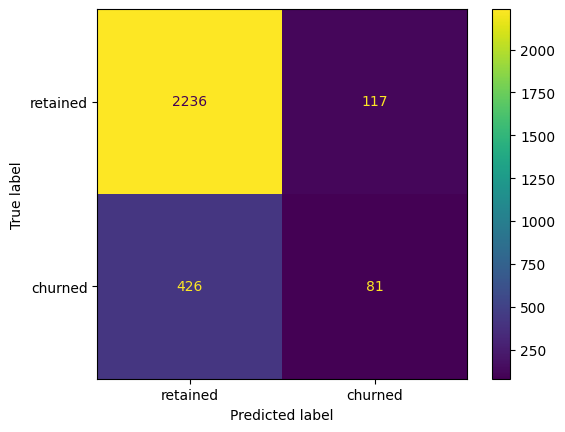

In [46]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels = xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['retained', 'churned'])
disp.plot(values_format = '');

### Confusion Matrix Analysis

From the confusion matrix, we can see that the champion model predicted **approximately three times as many false negatives as false positives**.  

It correctly identified only **15.9% of users who actually churned**, which aligns with the recall score observed earlier. This highlights that, while the model is fairly accurate overall, detecting churn remains a challenging task due to the class imbalance.

### Feature Importance

To better understand how the champion model makes predictions, we can use the `plot_importance` function to visualize the **most influential features**.  

This helps identify which features contribute the most to predicting churn and provides insights into the drivers behind the model's decisions.

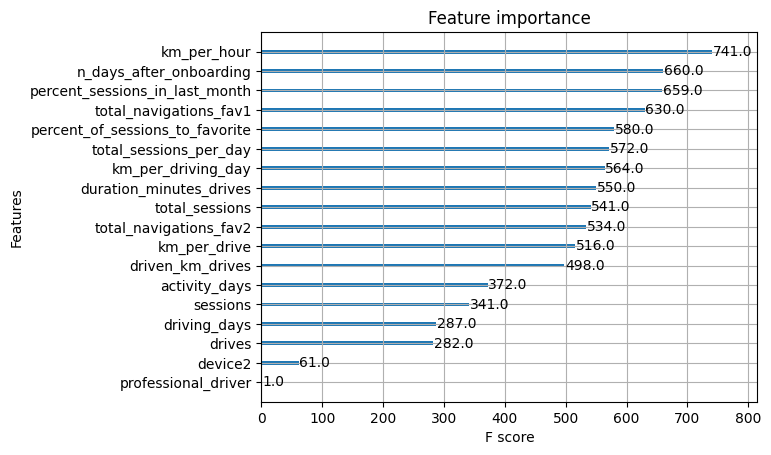

In [48]:
plot_importance(xgb_cv.best_estimator_);
plt.savefig('xgb_cv_feature_importance.png', dpi=300, bbox_inches='tight')

### Feature Importance Insights

- The XGBoost model utilized multiple features, unlike the previous Logistic Regression model, which relied heavily on a single feature (`activity_days`).  
- **Feature engineering matters:** Six of the top 10 features (and three of the top five) were engineered features, highlighting their importance in improving model performance.  
- **Feature importance varies across models:** Important features in one model may not be important in another due to complex feature interactions.  
- **Data limitations:** If the dataset lacks predictive signal, even advanced algorithms cannot produce highly accurate predictions.  
- **Value of analysis:** Even if the model cannot make strong predictions, the insights gained (e.g., key feature drivers of churn) can still be reported to stakeholders and inform decision-making.

## Results and Evaluation

- Two tree-based models, **Random Forest** and **XGBoost**, were developed for cross-comparison, using a **training/validation/test split** to ensure unbiased model selection and reliable estimates of future performance.  
- The **baseline Logistic Regression model** achieved moderate overall accuracy (82%) but had very low recall (9%) for the churned class, failing to identify most at-risk users.  
- On the validation set, **XGBoost** achieved a recall of 16.2% vs 12% for Random Forest, making it the **champion model**, better aligned with the business goal of identifying churned users.  
- Feature engineering played a critical role: **5 of the top 10 features** were engineered (e.g., `km_per_hour`, `percent_sessions_in_last_month`), demonstrating its value in improving model performance.  

## Conclusion

### Model Performance and Implications
- The final XGBoost model achieved **recall of 15.9%** and **accuracy of 80%** on the test set.  
- While tree-based ensembles outperformed the baseline Logistic Regression and required less preprocessing, the low recall means the model still **fails to identify many at-risk customers**, limiting its usefulness for churn intervention.  
- Despite this, the model provides **valuable exploratory insights** and a strong foundation for future refinement, highlighting key drivers of churn and important predictive features.  

### Recommendations and Next Steps
- **Improve recall:** Further feature engineering and advanced hyperparameter tuning could help identify more churned users.  
- **Enrich the dataset:** Incorporate detailed drive-level data (e.g., locations, user interaction patterns) to capture predictive signals not currently in the dataset.  
- **Experiment with variable combinations:** Testing different subsets of features may uncover stronger predictive relationships.  
- **Leverage insights for business decisions:** Even without perfect predictions, the model highlights key behavioral patterns that can inform interventions, guide product decisions, or inspire further research.  
